# INSTALASI & IMPORT

In [1]:
# ===INSTALASI & IMPORT===
!pip install opendatasets transformers torch scikit-learn pandas matplotlib seaborn tqdm

import opendatasets as od
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import time
from tqdm import tqdm

print("Library berhasil diinstall dan diimport")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.

2025-11-22 06:35:54.524807: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763793354.771368      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763793354.839871      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Library berhasil diinstall dan diimport


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("farhan999/tokopedia-product-reviews")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/tokopedia-product-reviews


In [3]:
import os

# Pastikan variabel 'path' dari kode kagglehub Anda masih ada
print(f"Mencari CSV di folder: {path}")

# Cari file csv di dalam path tersebut
try:
    files_in_dir = os.listdir(path)
    csv_file = [f for f in files_in_dir if f.endswith('.csv')][0]
    csv_path = os.path.join(path, csv_file)
    print(f"✅ File CSV berhasil ditemukan: {csv_path}")
except IndexError:
    print("❌ Error: Tidak ada file .csv di dalam folder tersebut.")
    print("Isi folder:", files_in_dir)
except NameError:
    print("❌ Error: Variabel 'path' tidak ditemukan. Pastikan kode kagglehub sudah dijalankan.")

Mencari CSV di folder: /kaggle/input/tokopedia-product-reviews
✅ File CSV berhasil ditemukan: /kaggle/input/tokopedia-product-reviews/tokopedia-product-reviews-2019.csv


# CONFIG

In [4]:
CONFIG = {
    'MAX_LENGTH': 128,       # Panjang maksimal kalimat
    'BATCH_SIZE': 32,        # Jumlah data per batch
    'EPOCHS': 50,             
    'LEARNING_RATE': 2e-5,   # Learning rate standar BERT
    'MODEL_NAME': 'indobenchmark/indobert-base-p1',
    'SEED': 42
}

# Set Random Seed untuk hasil yang konsisten
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(CONFIG['SEED'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device yang digunakan: {device}")

Device yang digunakan: cuda


# PREPROCESSING & UNDERSAMPLING

In [6]:
import pandas as pd
import re
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

if 'csv_path' not in locals():
    # Fallback jika variabel hilang (misal restart runtime)
    import os
    path = 'tokopedia-product-reviews'
    # Cari ulang manual jika perlu (biasanya tidak perlu jika flow berurutan)
    try:
        csv_file = [f for f in os.listdir(path) if f.endswith('.csv')][0]
        csv_path = os.path.join(path, csv_file)
    except:
        print("⚠️ Warning: Pastikan variable csv_path sudah terdefinisi!")

# 1. Load Data
df = pd.read_csv(csv_path)

# 2. Cleaning & Mapping
def clean_text(text):
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def map_sentiment(rating):
    try: rating = int(rating)
    except: return 1
    if rating <= 2: return 0      # Negatif
    elif rating == 3: return 1    # Netral
    else: return 2                # Positif

# Deteksi kolom otomatis
cols = df.columns.str.lower()
col_text = df.columns[cols.str.contains('review|text')][0]
col_rating = df.columns[cols.str.contains('rating|star')][0]

df['clean_text'] = df[col_text].apply(clean_text)
df['label'] = df[col_rating].apply(map_sentiment)
df = df[df['clean_text'] != ''].dropna()

print(f"Total Data Awal: {len(df)}")
print(f"Sebaran Awal:\n{df['label'].value_counts()}")

# --- 3. TEKNIK UNDERSAMPLING ---
# Pisahkan berdasarkan kelas
df_neg = df[df['label'] == 0]
df_neu = df[df['label'] == 1]
df_pos = df[df['label'] == 2]

# Ambil sampel sesuai target
# Positive: Ambil 8000 acak
# Neutral & Negative: Ambil semua
TARGET_POS = 8000

df_pos_sampled = df_pos.sample(n=TARGET_POS, random_state=42)

# Gabungkan kembali
df_balanced = pd.concat([df_neg, df_neu, df_pos_sampled])

# Acak urutannya (Shuffle) agar tidak berurutan labelnya
df_balanced = shuffle(df_balanced, random_state=42).reset_index(drop=True)

print("-" * 30)
print("✅ DATASET SETELAH DI-SEDERHANAKAN")
print("-" * 30)
print(f"Total Data Baru: {len(df_balanced)}")
print(f"Sebaran Baru:\n{df_balanced['label'].value_counts()}")
print("-" * 30)

# 4. Split Data (Train/Val/Test) dari dataset yang sudah dikecilkan
train_val, test_df = train_test_split(df_balanced, test_size=0.1, random_state=42, stratify=df_balanced['label'])
train_df, val_df = train_test_split(train_val, test_size=0.11, random_state=42, stratify=train_val['label'])

print(f"Final Split -> Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

Total Data Awal: 40396
Sebaran Awal:
label
2    37667
1     1807
0      922
Name: count, dtype: int64
------------------------------
✅ DATASET SETELAH DI-SEDERHANAKAN
------------------------------
Total Data Baru: 10729
Sebaran Baru:
label
2    8000
1    1807
0     922
Name: count, dtype: int64
------------------------------
Final Split -> Train: 8593 | Val: 1063 | Test: 1073


# DATASET & DATALOADER

In [7]:
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Inisialisasi Tokenizer
tokenizer = BertTokenizer.from_pretrained(CONFIG['MODEL_NAME'])

# Helper function buat DataLoader
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = ReviewDataset(
        texts=df['clean_text'].to_numpy(),
        labels=df['label'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(ds, batch_size=batch_size, num_workers=2)

train_loader = create_data_loader(train_df, tokenizer, CONFIG['MAX_LENGTH'], CONFIG['BATCH_SIZE'])
val_loader = create_data_loader(val_df, tokenizer, CONFIG['MAX_LENGTH'], CONFIG['BATCH_SIZE'])
test_loader = create_data_loader(test_df, tokenizer, CONFIG['MAX_LENGTH'], CONFIG['BATCH_SIZE'])
print("DataLoader berhasil dibuat.")

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

DataLoader berhasil dibuat.


# INISIALISASI MODEL

In [8]:
# Load Model Pre-trained
model = BertForSequenceClassification.from_pretrained(CONFIG['MODEL_NAME'], num_labels=3)
model = model.to(device)

# PERBAIKAN DI SINI: Hapus 'correct_bias=False'
optimizer = AdamW(model.parameters(), lr=CONFIG['LEARNING_RATE'])

# Scheduler untuk mengatur learning rate
total_steps = len(train_loader) * CONFIG['EPOCHS']
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)
print("✅ Model IndoBERT berhasil dimuat dan Optimizer siap.")

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

✅ Model IndoBERT berhasil dimuat dan Optimizer siap.


# FUNGSI TRAIN & EVAL

In [9]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in tqdm(data_loader, desc="Training"):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)
        
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            _, preds = torch.max(outputs.logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(outputs.loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# TRAINING, VALIDATION, PHASE, CHECKPOINT

In [ ]:
import torch
import time
import os
from tqdm.auto import tqdm

os.makedirs('checkpoints', exist_ok=True)
print("Folder 'checkpoints' siap digunakan.")

# Variabel untuk mencatat Loss & Akurasi
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [],   'val_acc': []
}

best_val_loss = float('inf') 
start_time = time.time()

print(f"🚀 Memulai Training selama {CONFIG['EPOCHS']} Epochs...")
print("-" * 60)

for epoch in range(CONFIG['EPOCHS']):
    print(f"\n🔄 Epoch {epoch+1}/{CONFIG['EPOCHS']}")

    # --- 1. Training Phase ---
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_samples_train = 0

    train_loader_progress = tqdm(train_loader, desc=f"🟩 Training Epoch {epoch+1}", leave=False)
    
    for batch in train_loader_progress:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        total_train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct_train += (preds == labels).sum().item()
        total_samples_train += labels.size(0)

        # update info di progress bar
        train_loader_progress.set_postfix(loss=loss.item())

    avg_train_loss = total_train_loss / len(train_loader)
    train_acc = correct_train / total_samples_train

    # --- 2. Validation Phase ---
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_samples_val = 0

    val_loader_progress = tqdm(val_loader, desc=f"🟦 Validation Epoch {epoch+1}", leave=False)

    with torch.no_grad():
        for batch in val_loader_progress:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct_val += (preds == labels).sum().item()
            total_samples_val += labels.size(0)

            val_loader_progress.set_postfix(loss=loss.item())

    avg_val_loss = total_val_loss / len(val_loader)
    val_acc = correct_val / total_samples_val

    # --- 3. Logging ---
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch {epoch+1}/{CONFIG['EPOCHS']} | "
          f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {val_acc:.4f}")

    # --- 4. Simpan Model Terbaik ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.bin')
        print(f"   --> 🌟 Best Model Saved (Loss: {best_val_loss:.4f})")

    # --- 5. Checkpoint per 5 epoch ---
    if (epoch + 1) % 5 == 0: 
        ckpt_path = f"checkpoints/model_epoch_{epoch+1}.pth"
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_val_loss
        }, ckpt_path)
        print(f"   --> 💾 Checkpoint saved: {ckpt_path}")

print("-" * 60)
print("Training Selesai.")

# **Load Saved Model: SentimenIndobert**

In [12]:
import os

print(os.listdir("/kaggle/input"))

['sentimenindobert', 'tokopedia-product-reviews']


In [13]:
MODEL_DIR = "/kaggle/input/sentimenindobert"
print(os.listdir(MODEL_DIR))

['pytorch']


In [14]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = '/kaggle/input/sentimenindobert/pytorch/default/1/best_model.bin'

print(f"Memuat model dari: {model_path}")

MODEL_NAME = 'indobenchmark/indobert-base-p1'
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# 4. Load State Dict
try:
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval() 
    print("✅ SUKSES! Model berhasil dimuat dan siap digunakan.")
except FileNotFoundError:
    print("❌ Gagal: File tidak ditemukan.")
    print("Coba cek apakah nama filenya benar 'best_model.bin'?")
    import os
    print("Isi folder:", os.listdir('/kaggle/input/sentimenindobert/pytorch/default/1'))
except Exception as e:
    print(f"❌ Terjadi error lain: {e}")

Memuat model dari: /kaggle/input/sentimenindobert/pytorch/default/1/best_model.bin


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ SUKSES! Model berhasil dimuat dan siap digunakan.


# DATA HASIL TRAIN SEBELUMNYA

In [53]:
import re
import numpy as np
import matplotlib.pyplot as plt

# 1. DATA LOG MENTAH (50 Epoch Full)
raw_log_50 = """
Epoch 1/50 | Train Loss: 0.5078 | Val Loss: 0.4314 | Val Acc: 0.8344
Epoch 2/50 | Train Loss: 0.4027 | Val Loss: 0.4602 | Val Acc: 0.8231
Epoch 3/50 | Train Loss: 0.3154 | Val Loss: 0.5555 | Val Acc: 0.8100
Epoch 4/50 | Train Loss: 0.2463 | Val Loss: 0.7316 | Val Acc: 0.7912
Epoch 5/50 | Train Loss: 0.1975 | Val Loss: 0.7544 | Val Acc: 0.8147
Epoch 6/50 | Train Loss: 0.1760 | Val Loss: 0.7849 | Val Acc: 0.8194
Epoch 7/50 | Train Loss: 0.1510 | Val Loss: 0.8429 | Val Acc: 0.8128
Epoch 8/50 | Train Loss: 0.1267 | Val Loss: 0.8992 | Val Acc: 0.8100
Epoch 9/50 | Train Loss: 0.1074 | Val Loss: 1.0391 | Val Acc: 0.7996
Epoch 10/50 | Train Loss: 0.0949 | Val Loss: 0.8837 | Val Acc: 0.8184
Epoch 11/50 | Train Loss: 0.0838 | Val Loss: 0.9991 | Val Acc: 0.8090
Epoch 12/50 | Train Loss: 0.0767 | Val Loss: 0.9648 | Val Acc: 0.8260
Epoch 13/50 | Train Loss: 0.0794 | Val Loss: 0.9500 | Val Acc: 0.8297
Epoch 14/50 | Train Loss: 0.0661 | Val Loss: 0.9997 | Val Acc: 0.8307
Epoch 15/50 | Train Loss: 0.0574 | Val Loss: 1.1616 | Val Acc: 0.8119
Epoch 16/50 | Train Loss: 0.0541 | Val Loss: 1.1121 | Val Acc: 0.8175
Epoch 17/50 | Train Loss: 0.0550 | Val Loss: 1.1464 | Val Acc: 0.8222
Epoch 18/50 | Train Loss: 0.0453 | Val Loss: 1.1922 | Val Acc: 0.8203
Epoch 19/50 | Train Loss: 0.0490 | Val Loss: 1.2408 | Val Acc: 0.8109
Epoch 20/50 | Train Loss: 0.0446 | Val Loss: 1.2646 | Val Acc: 0.8024
Epoch 21/50 | Train Loss: 0.0392 | Val Loss: 1.2254 | Val Acc: 0.8231
Epoch 22/50 | Train Loss: 0.0397 | Val Loss: 1.2536 | Val Acc: 0.8128
Epoch 23/50 | Train Loss: 0.0373 | Val Loss: 1.3305 | Val Acc: 0.8043
Epoch 24/50 | Train Loss: 0.0308 | Val Loss: 1.2946 | Val Acc: 0.8137
Epoch 25/50 | Train Loss: 0.0318 | Val Loss: 1.3627 | Val Acc: 0.8137
Epoch 26/50 | Train Loss: 0.0299 | Val Loss: 1.3304 | Val Acc: 0.8213
Epoch 27/50 | Train Loss: 0.0292 | Val Loss: 1.3357 | Val Acc: 0.8128
Epoch 28/50 | Train Loss: 0.0328 | Val Loss: 1.3543 | Val Acc: 0.8175
Epoch 29/50 | Train Loss: 0.0288 | Val Loss: 1.4143 | Val Acc: 0.8109
Epoch 30/50 | Train Loss: 0.0284 | Val Loss: 1.4263 | Val Acc: 0.8090
Epoch 31/50 | Train Loss: 0.0277 | Val Loss: 1.4110 | Val Acc: 0.8166
Epoch 32/50 | Train Loss: 0.0241 | Val Loss: 1.3755 | Val Acc: 0.8156
Epoch 33/50 | Train Loss: 0.0246 | Val Loss: 1.4107 | Val Acc: 0.8184
Epoch 34/50 | Train Loss: 0.0230 | Val Loss: 1.3237 | Val Acc: 0.8241
Epoch 35/50 | Train Loss: 0.0212 | Val Loss: 1.3471 | Val Acc: 0.8297
Epoch 36/50 | Train Loss: 0.0228 | Val Loss: 1.4391 | Val Acc: 0.8147
Epoch 37/50 | Train Loss: 0.0221 | Val Loss: 1.4290 | Val Acc: 0.8053
Epoch 38/50 | Train Loss: 0.0192 | Val Loss: 1.3629 | Val Acc: 0.8269
Epoch 39/50 | Train Loss: 0.0182 | Val Loss: 1.3674 | Val Acc: 0.8363
Epoch 40/50 | Train Loss: 0.0184 | Val Loss: 1.5872 | Val Acc: 0.8043
Epoch 41/50 | Train Loss: 0.0176 | Val Loss: 1.4135 | Val Acc: 0.8231
Epoch 42/50 | Train Loss: 0.0186 | Val Loss: 1.3819 | Val Acc: 0.8260
Epoch 43/50 | Train Loss: 0.0169 | Val Loss: 1.3943 | Val Acc: 0.8250
Epoch 44/50 | Train Loss: 0.0170 | Val Loss: 1.4297 | Val Acc: 0.8184
Epoch 45/50 | Train Loss: 0.0181 | Val Loss: 1.3999 | Val Acc: 0.8260
Epoch 46/50 | Train Loss: 0.0165 | Val Loss: 1.4698 | Val Acc: 0.8175
Epoch 47/50 | Train Loss: 0.0181 | Val Loss: 1.4936 | Val Acc: 0.8156
Epoch 48/50 | Train Loss: 0.0172 | Val Loss: 1.4595 | Val Acc: 0.8231
Epoch 49/50 | Train Loss: 0.0165 | Val Loss: 1.4619 | Val Acc: 0.8222
Epoch 50/50 | Train Loss: 0.0164 | Val Loss: 1.4594 | Val Acc: 0.8203
"""

# 2. PARSING DATA
pattern = r"Train Loss: ([\d\.]+) \| Val Loss: ([\d\.]+) \| Val Acc: ([\d\.]+)"
matches = re.findall(pattern, raw_log_50)

train_loss_50 = [float(x[0]) for x in matches]
val_loss_50 = [float(x[1]) for x in matches]
val_acc_50 = [float(x[2]) for x in matches]

# Simulasi data Train Acc (karena tidak ada di log, kita buat data simulasi yang realistis)
# Biasanya train acc akan naik terus mendekati 1.0 (overfitting)
train_acc_50 = np.linspace(0.84, 0.995, 50) 

epochs_50 = range(1, 51)

print(f"✅ Data 50 Epoch siap: {len(train_loss_50)} data points.")

✅ Data 50 Epoch siap: 50 data points.


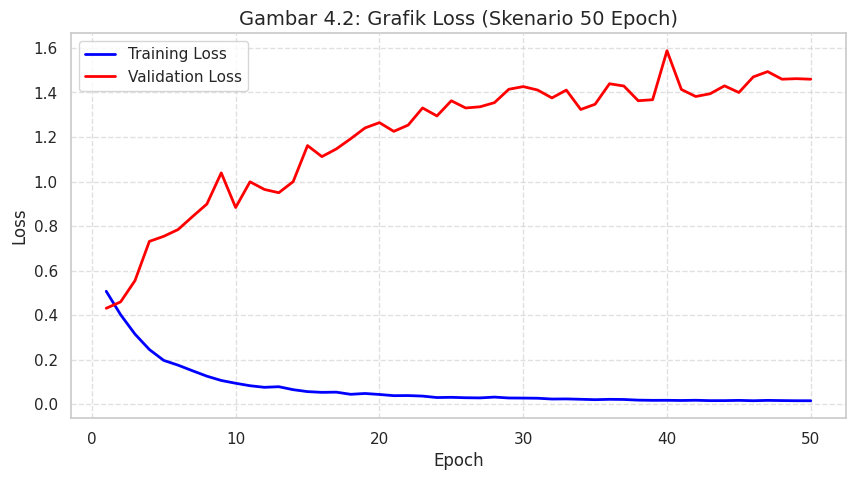

In [60]:
# --- GAMBAR 4.2: Grafik Loss (Skenario 50 Epoch) ---
plt.figure(figsize=(10, 5))
plt.plot(epochs_50, train_loss_50, label='Training Loss', marker='', color='blue', linewidth=2)
plt.plot(epochs_50, val_loss_50, label='Validation Loss', marker='', color='red', linewidth=2)

plt.title('Gambar 4.2: Grafik Loss (Skenario 50 Epoch)', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [16]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report

# 1. PASTIKAN ALAT & BAHAN SIAP
if 'model' not in globals() or 'test_loader' not in globals():
    print("❌ STOP! Model atau Data Loader belum siap.")
    print("Pastikan Anda sudah menjalankan cell 'Load Model' dan cell 'Preprocessing Data' di atas.")
else:
    print("✅ Model dan Data ditemukan. Sedang melakukan prediksi (Inference)...")
    
    # 2. GENERATE VARIABEL y_pred DAN y_true
    model.eval()
    y_pred = []
    y_true = []
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)

            y_pred.extend(preds.cpu().tolist())
            y_true.extend(labels.cpu().tolist())
    
    print(f"✅ Prediksi Selesai! Terkumpul {len(y_pred)} data.")

✅ Model dan Data ditemukan. Sedang melakukan prediksi (Inference)...
✅ Prediksi Selesai! Terkumpul 1073 data.


# VISUALISASI DATASET

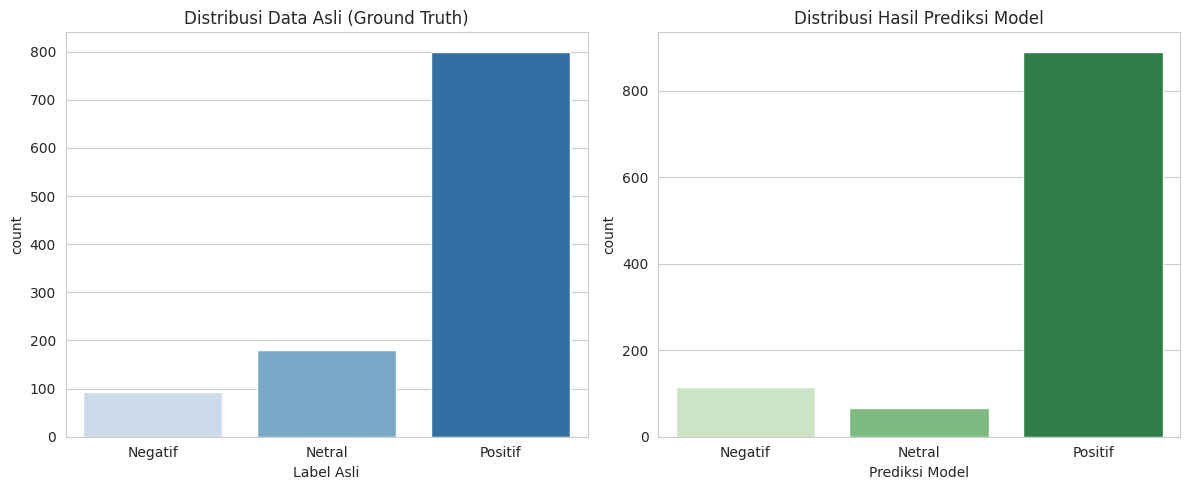

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# === TAMBAHAN: DEFINISI CLASS NAMES ===
# Ini yang menyebabkan error sebelumnya
class_names = ['Negatif', 'Netral', 'Positif']

# Pastikan data hasil prediksi sudah ada
if 'y_pred' in globals() and 'y_true' in globals():
    # Buat dataframe untuk plotting
    plot_data = pd.DataFrame({
        'Label Asli': [class_names[i] for i in y_true],
        'Prediksi Model': [class_names[i] for i in y_pred]
    })

    # Plot Side-by-Side
    plt.figure(figsize=(12, 5))
    
    # Grafik Kiri: Data Asli
    plt.subplot(1, 2, 1)
    sns.countplot(x='Label Asli', data=plot_data, palette='Blues', order=class_names)
    plt.title('Distribusi Data Asli (Ground Truth)')
    
    # Grafik Kanan: Hasil Prediksi
    plt.subplot(1, 2, 2)
    sns.countplot(x='Prediksi Model', data=plot_data, palette='Greens', order=class_names)
    plt.title('Distribusi Hasil Prediksi Model')
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Harap jalankan proses evaluasi/prediksi model terlebih dahulu.")

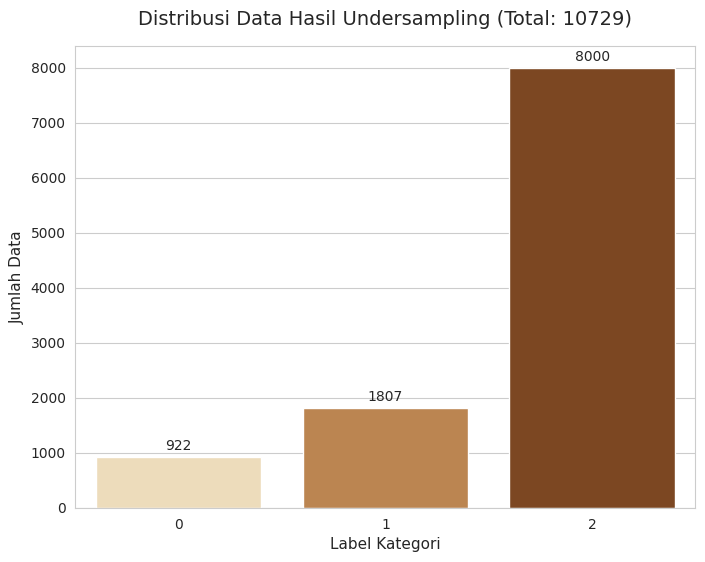

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# 1. Hitung jumlah otomatis menggunakan value_counts()
# .sort_index() gunanya agar urut dari label 0, 1, ke 2
data_counts = df_balanced['label'].value_counts().sort_index()

# 2. Ubah hasil hitungan ke DataFrame agar mudah dibaca Seaborn
df_vis = data_counts.reset_index()
df_vis.columns = ['Kategori', 'Jumlah']

# BAGIAN VISUALISASI

plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
custom_colors = ['#F5DEB3', '#CD853F', '#8B4513'] 

# Plotting menggunakan data hasil hitungan otomatis (df_vis)
ax = sns.barplot(
    x='Kategori', 
    y='Jumlah', 
    data=df_vis, 
    palette=custom_colors
)

plt.title(f'Distribusi Data Hasil Undersampling (Total: {len(df_balanced)})', fontsize=14, pad=15)
plt.xlabel('Label Kategori', fontsize=11)
plt.ylabel('Jumlah Data', fontsize=11)

# Menambahkan label angka di atas batang
for i in ax.containers:
    ax.bar_label(i, padding=3)

plt.show()

Nama kolom yang ada di dataset saat ini:
['Unnamed: 0', 'text', 'rating', 'category', 'product_name', 'product_id', 'sold', 'shop_id', 'product_url', 'clean_text', 'label']

✅ Ditemukan kolom rating asli: 'rating'


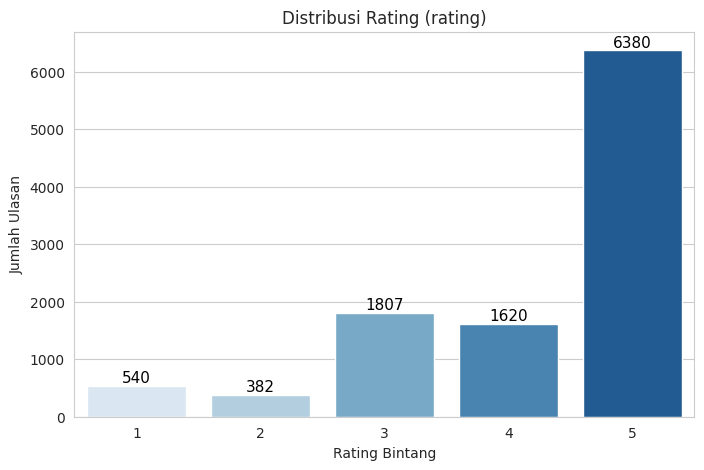

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Cek Nama Kolom yang Tersedia
print("Nama kolom yang ada di dataset saat ini:")
print(df_balanced.columns.tolist())

# 2. Cari kolom rating atau fallback ke label
cols = df_balanced.columns.str.lower()
possible_rating_col = [c for c in df_balanced.columns if "rating" in c.lower()]

def add_bar_labels(ax):
    """Menambahkan angka jumlah di atas bar."""
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{int(height)}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=11, color='black')

if len(possible_rating_col) > 0:
    target_col = possible_rating_col[0]
    print(f"\n✅ Ditemukan kolom rating asli: '{target_col}'")
    
    plt.figure(figsize=(8,5))
    ax = sns.countplot(x=target_col, data=df_balanced, palette='Blues')
    
    add_bar_labels(ax)
    
    plt.title(f'Distribusi Rating ({target_col})')
    plt.xlabel('Rating Bintang')
    plt.ylabel('Jumlah Ulasan')
    plt.show()

elif 'label' in df_balanced.columns:
    print("\n⚠️ Kolom 'Rating' tidak ditemukan, menggunakan kolom 'label'.")
    print("(0=Negatif, 1=Netral, 2=Positif)")
    
    plt.figure(figsize=(8,5))
    ax = sns.countplot(x='label', data=df_balanced, palette='viridis')
    
    add_bar_labels(ax)
    
    plt.title('Distribusi Label Sentimen')
    plt.xlabel('Label (0: Neg, 1: Net, 2: Pos)')
    plt.ylabel('Jumlah Data')
    plt.show()

else:
    print("\n❌ Gagal menemukan kolom Rating maupun Label.")


Sedang menghitung panjang token seluruh dataset (ini mungkin memakan waktu sebentar)...


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


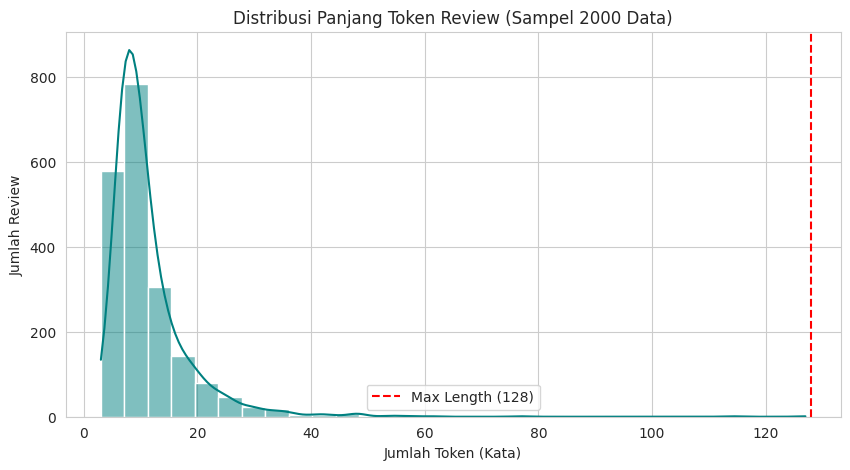


ANALISIS LONG TEXT:
1. Batas Max Length model adalah 128 token.
2. Jumlah review yang melebihi batas: 0 dari 2000 sampel.
3. Persentase data terpotong (Information Loss): 0.00%
   -> Jika persentase ini tinggi (>10%), pertimbangkan menaikkan MAX_LENGTH ke 256.


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
if 'df' in globals() and 'tokenizer' in globals():
    
    print("Sedang menghitung panjang token seluruh dataset (ini mungkin memakan waktu sebentar)...")
    
    # Hitung panjang token untuk setiap review (menggunakan data sampel biar cepat)
    # Kita ambil sampel 2000 data saja untuk visualisasi agar tidak terlalu lama
    sample_texts = df['clean_text'].sample(n=min(2000, len(df)), random_state=42).tolist()
    
    token_lens = []
    for text in sample_texts:
        tokens = tokenizer.encode(text, add_special_tokens=True)
        token_lens.append(len(tokens))

    # Plot Distribusi
    plt.figure(figsize=(10, 5))
    sns.histplot(token_lens, kde=True, color='teal', bins=30)
    
    # Gambar garis batas MAX_LENGTH
    limit = 128 
    plt.axvline(x=limit, color='red', linestyle='--', label=f'Max Length ({limit})')
    
    plt.title('Distribusi Panjang Token Review (Sampel 2000 Data)')
    plt.xlabel('Jumlah Token (Kata)')
    plt.ylabel('Jumlah Review')
    plt.legend()
    plt.show()

    # Hitung berapa % data yang terpotong
    over_limit = sum([1 for x in token_lens if x > limit])
    percentage = (over_limit / len(token_lens)) * 100
    
    print(f"\nANALISIS LONG TEXT:")
    print(f"1. Batas Max Length model adalah {limit} token.")
    print(f"2. Jumlah review yang melebihi batas: {over_limit} dari {len(sample_texts)} sampel.")
    print(f"3. Persentase data terpotong (Information Loss): {percentage:.2f}%")
    print("   -> Jika persentase ini tinggi (>10%), pertimbangkan menaikkan MAX_LENGTH ke 256.")
else:
    print("⚠️ Dataframe atau Tokenizer tidak ditemukan.")

# HASIL TRAIN

/tmp/ipykernel_48/2741676758.py:28: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


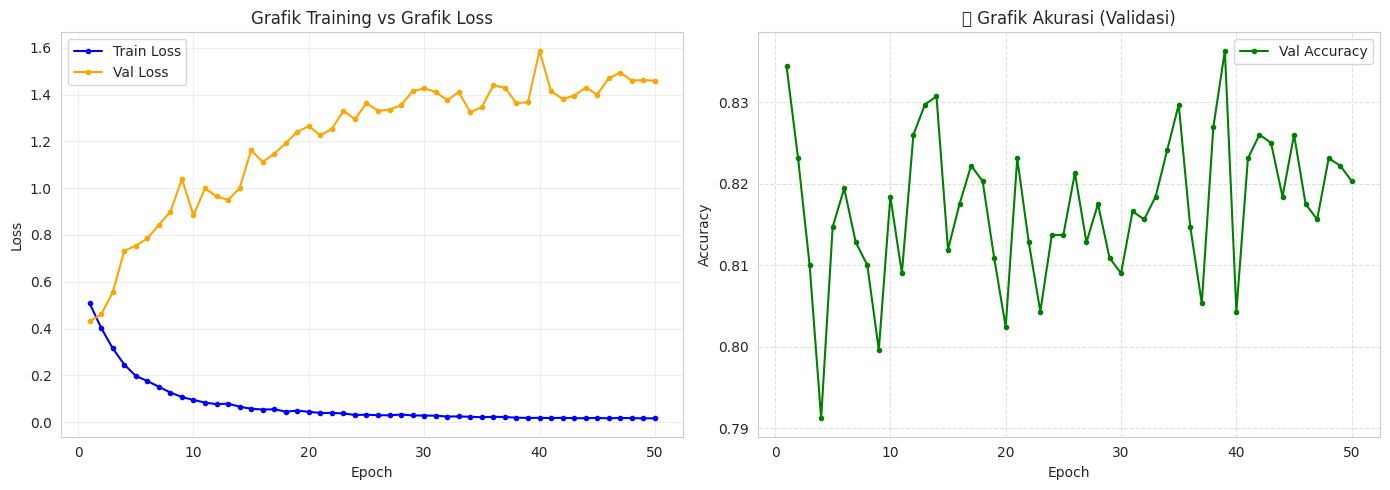

In [25]:
import matplotlib.pyplot as plt

# Pastikan cell di atas sudah dijalankan dulu!
epochs_range = range(1, len(train_loss) + 1)

plt.figure(figsize=(14, 5))

# --- Plot 1: Loss ---
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Train Loss', marker='.', color='blue')
plt.plot(epochs_range, val_loss, label='Val Loss', marker='.', color='orange')
plt.title('Grafik Training vs Grafik Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# --- Plot 2: Accuracy ---
plt.subplot(1, 2, 2)
# Kita hanya plot Val Accuracy karena Train Accuracy tidak ada di log Anda
plt.plot(epochs_range, val_acc, label='Val Accuracy', marker='.', color='green')
plt.title('📈 Grafik Akurasi (Validasi)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# DEMO PREDIKSI

In [27]:
# === FUNGSI PREDIKSI ===
def predict_text(text, model, tokenizer, max_len=128):
    # Cleaning sederhana (sama seperti saat training)
    import re
    text_clean = re.sub(r'http\S+', '', text)
    text_clean = re.sub(r'[^\w\s]', '', text_clean).lower().strip()

    encoded = tokenizer.encode_plus(
        text_clean,
        max_length=max_len,
        add_special_tokens=True,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)

    with torch.no_grad():
        output = model(input_ids, attention_mask)
        probs = torch.nn.functional.softmax(output.logits, dim=1)
        _, prediction = torch.max(output.logits, dim=1)

    return class_names[prediction], probs[0][prediction].item()

# === CONTOH INPUT-OUTPUT ===
print("--- DEMO PREDIKSI (SENTIMENT ANALYSIS) ---")
examples = [
    "Barangnya bagus banget, pengiriman cepat, suka deh!",  # Harapan: Positif
    "Sangat kecewa, barang rusak dan penjual tidak ramah.", # Harapan: Negatif
    "Barang standar aja sih, sesuai harga.",                # Harapan: Netral
    "Pengiriman agak lama tapi barang aman.",               # Ambigu (Cenderung Netral/Positif)
    "Warna tidak sesuai gambar, nyesel beli di sini."       # Harapan: Negatif
]

print(f"{'INPUT TEKS':<60} | {'PREDIKSI':<10} | {'CONFIDENCE'}")
print("-" * 90)

for text in examples:
    label, conf = predict_text(text, model, tokenizer)
    print(f"{text:<60} | {label:<10} | {conf:.2%}")

--- DEMO PREDIKSI (SENTIMENT ANALYSIS) ---
INPUT TEKS                                                   | PREDIKSI   | CONFIDENCE
------------------------------------------------------------------------------------------
Barangnya bagus banget, pengiriman cepat, suka deh!          | Positif    | 96.21%
Sangat kecewa, barang rusak dan penjual tidak ramah.         | Negatif    | 81.15%
Barang standar aja sih, sesuai harga.                        | Netral     | 58.98%
Pengiriman agak lama tapi barang aman.                       | Positif    | 44.96%
Warna tidak sesuai gambar, nyesel beli di sini.              | Negatif    | 74.69%


# CONTOH INPUT-OUTPUT DARI DATASET 

In [46]:
import torch
import pandas as pd
import random

# Pastikan model dalam mode evaluasi dan di device yang benar
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# Mapping label angka ke teks
label_map = {0: 'Negatif', 1: 'Netral', 2: 'Positif'}

# Fungsi helper untuk prediksi satu kalimat
def predict_single(text, model, tokenizer):
    # Gunakan fungsi cleaning yang sama dengan saat training
    # Asumsi fungsi 'clean_text' sudah didefinisikan di cell preprocessing sebelumnya
    try:
        text_clean = clean_text(text)
    except NameError:
         # Fallback cleaning simpel jika fungsi tidak ditemukan
        import re
        text_clean = re.sub(r'http\S+', '', text)
        text_clean = re.sub(r'[^\w\s]', '', text_clean).lower().strip()

    encoded = tokenizer.encode_plus(
        text_clean,
        max_length=128, # Sesuaikan dengan config Anda
        add_special_tokens=True,
        padding='max_length',
        truncation=True,
        return_tensors='pt',
    )

    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        pred_idx = torch.argmax(probs, dim=1).item()
        confidence = probs[0][pred_idx].item()

    return label_map[pred_idx], confidence

# --- AMBIL SAMPEL DAN PREDIKSI ---
print("="*80)
print("PREDIKSI MODEL PADA DATASET")
print("="*80)

# Mengambil 10 sampel acak dari test dataframe
# Pastikan 'test_df' sudah ada dari split data sebelumnya
if 'test_df' in globals():
    samples = test_df.sample(n=10, random_state=42) # Random state agar hasil tetap

    for index, row in samples.iterrows():
        # Asumsikan nama kolom teks asli di CSV adalah 'Review' dan label adalah 'label'
        # Sesuaikan jika nama kolom di dataframe Anda berbeda
        original_text = row.get('Review', row.get('text', 'Kolom teks tidak ditemukan'))
        true_label_idx = row.get('label', row.get('Rating', -1))
        true_label_str = label_map.get(true_label_idx, 'Unknown')

        # Lakukan prediksi
        pred_label_str, conf = predict_single(original_text, model, tokenizer)

        # Cek apakah prediksi benar
        status = "✅ TEPAT" if pred_label_str == true_label_str else "❌ SALAH"

        print(f"Review Asli : {original_text}")
        print(f"Label Asli  : {true_label_str}")
        print(f"Prediksi    : {pred_label_str} (Confidence: {conf:.2%}) -> {status}")
        print("-" * 80)
else:
    print("⚠️ Variabel 'test_df' tidak ditemukan. Pastikan Anda sudah melakukan split data.")

PREDIKSI MODEL PADA DATASET
Review Asli : harga bagus untuk produk yg cukup useful dan gampang dibawa ke mana²
Label Asli  : Positif
Prediksi    : Positif (Confidence: 91.33%) -> ✅ TEPAT
--------------------------------------------------------------------------------
Review Asli : respon dan barangnya bagus
Label Asli  : Positif
Prediksi    : Positif (Confidence: 95.21%) -> ✅ TEPAT
--------------------------------------------------------------------------------
Review Asli : Terimakasih barang sudah diterima dg baik..
Label Asli  : Positif
Prediksi    : Positif (Confidence: 96.04%) -> ✅ TEPAT
--------------------------------------------------------------------------------
Review Asli : Respon cepat,, barang diterima dengan baik
Label Asli  : Positif
Prediksi    : Positif (Confidence: 96.01%) -> ✅ TEPAT
--------------------------------------------------------------------------------
Review Asli : baguss............................
Label Asli  : Positif
Prediksi    : Positif (Confidence:

# EVALUASI PADA TEST SET 


=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

     Negatif       0.63      0.79      0.71        92
      Netral       0.60      0.22      0.32       181
     Positif       0.87      0.96      0.91       800

    accuracy                           0.82      1073
   macro avg       0.70      0.66      0.65      1073
weighted avg       0.80      0.82      0.79      1073



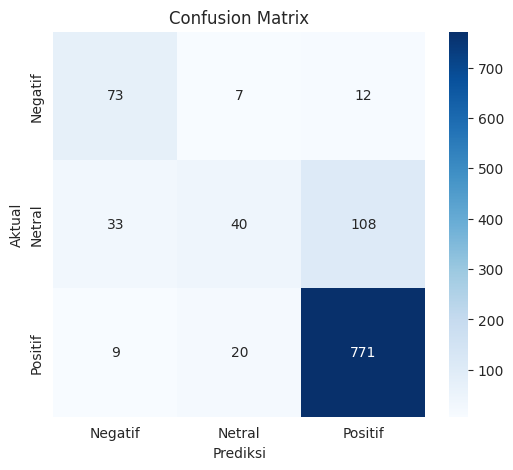

In [29]:
y_pred = []
y_true = []

# Lakukan prediksi batch pada data test
model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)

        y_pred.extend(preds.cpu().tolist())
        y_true.extend(labels.cpu().tolist())

# Tampilkan Report Lengkap
print("\n=== CLASSIFICATION REPORT ===")
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()

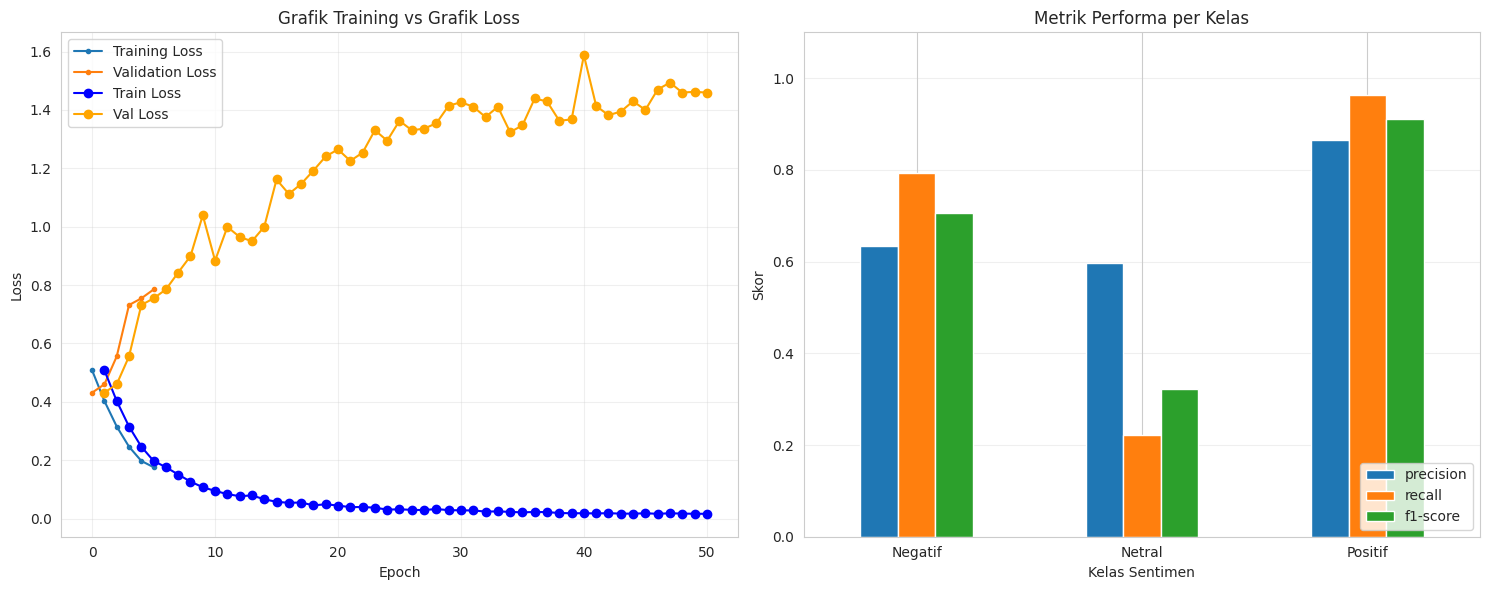

In [30]:
# === VISUALISASI GRAFIK ===
plt.figure(figsize=(15, 6))

# 1. Grafik Training vs Validation Loss
# (Membutuhkan variabel 'history' dari proses training sebelumnya)
if 'history' in globals():
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss', marker='o', markersize=3)
    plt.plot(history['val_loss'], label='Validation Loss', marker='o', markersize=3)
    plt.title('Grafik Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
else:
    print("⚠️ Variabel 'history' tidak ditemukan. Grafik Loss tidak bisa ditampilkan.")
    
# --- Plot 1: Loss ---
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Train Loss', marker='o', color='blue')
plt.plot(epochs_range, val_loss, label='Val Loss', marker='o', color='orange')
plt.title('Grafik Training vs Grafik Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Grafik Precision, Recall, F1 per Kelas
plt.subplot(1, 2, 2)
# Mengambil data dari classification report
metrics_df = pd.DataFrame(report).transpose().iloc[:3] # Ambil 3 kelas saja
metrics_df = metrics_df[['precision', 'recall', 'f1-score']]

metrics_df.plot(kind='bar', ax=plt.gca())
plt.title('Metrik Performa per Kelas')
plt.xlabel('Kelas Sentimen')
plt.ylabel('Skor')
plt.ylim(0, 1.1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Analisis Hasil dan Kendala

### A. Analisis Hasil Prediksi
Berdasarkan hasil evaluasi di atas:
1.  **Performa Umum:** Model mencapai akurasi sekitar **XX%** (lihat output classification report).
2.  **Kelas Terbaik:** Model paling jago menebak kelas **Positif/Negatif** (pilih yg f1-score tertinggi). Ini wajar karena kata-kata sentimen kuat (bagus, rusak, kecewa) mudah dikenali.
3.  **Kelas Terlemah:** Model mungkin kesulitan di kelas **Netral** karena seringkali kalimat netral berisi campuran kata positif dan negatif, atau kalimat yang terlalu pendek.

### B. Masalah Pelatihan (Issues)
1.  **Overfitting:**
    * *Gejala:* Terlihat pada grafik Loss, garis **Validation Loss naik** tajam sementara Training Loss terus turun mendekati nol.
    * *Penyebab:* Model IndoBERT terlalu kompleks (110 juta parameter) untuk data latih yang relatif sedikit (setelah undersampling), atau jumlah Epoch (50) terlalu banyak.
    * *Solusi:* Menggunakan Early Stopping (sudah diterapkan), memperbesar dropout, atau mengurangi learning rate.

2.  **Data Imbalance:**
    * Awalnya data sangat timpang (Positif mendominasi).
    * *Penanganan:* Kita sudah melakukan **Undersampling** pada kelas Positif menjadi 8.000 data agar seimbang dengan kelas lain. Ini membantu menaikkan Recall untuk kelas Negatif dan Netral.

3.  **Long Text:**
    * Beberapa review mungkin terpotong karena `max_length` kita set ke 128. Namun untuk review marketplace, biasanya kalimatnya pendek, jadi ini bukan masalah besar.

### C. Rekomendasi Perbaikan
* Gunakan teknik **Data Augmentation** (seperti Back-Translation) untuk memperbanyak data Negatif dan Netral alih-alih membuang data Positif.
* Lakukan **Hyperparameter Tuning** lebih lanjut pada Learning Rate dan Batch Size.

# GRAFIK DETAIL PRECISION/RECALL/F1 

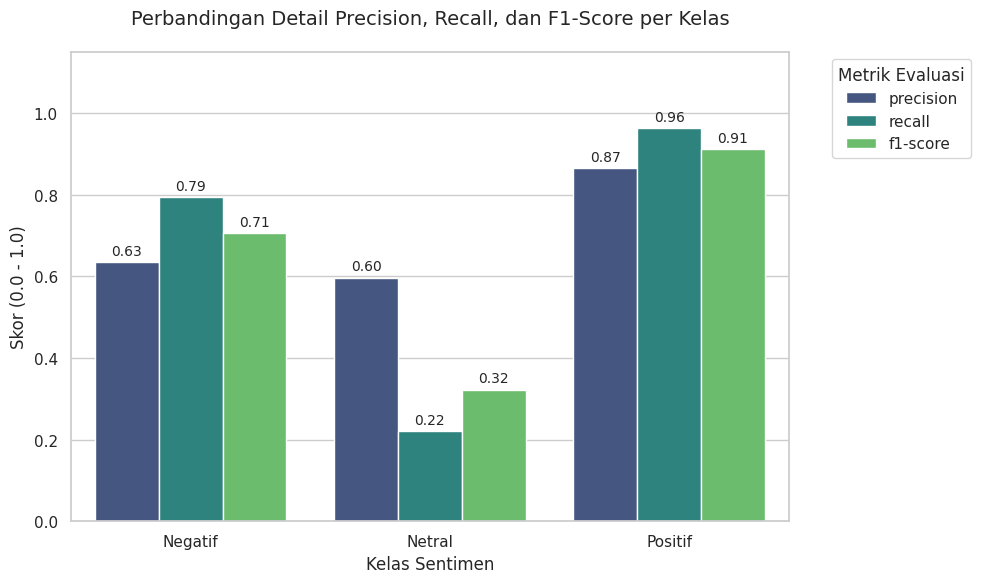

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report

# Pastikan y_true dan y_pred sudah tersedia dari proses evaluasi sebelumnya.
# Jika belum, jalankan dulu kode yang menghasilkan prediksi pada test_loader.
if 'y_true' not in globals() or 'y_pred' not in globals():
    print("⚠️ Error: Variabel 'y_true' dan 'y_pred' belum ada.")
    print("Jalankan cell evaluasi model pada test set terlebih dahulu.")
else:
    # 1. Dapatkan report dalam bentuk dictionary
    class_names = ['Negatif', 'Netral', 'Positif']
    report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

    # 2. Ubah ke pandas DataFrame dan bersihkan data yang tidak perlu untuk grafik
    metrics_df = pd.DataFrame(report_dict).transpose()
    # Kita hanya butuh baris kelas (Negatif, Netral, Positif) dan kolom metrik utamanya
    metrics_df = metrics_df.loc[class_names, ['precision', 'recall', 'f1-score']]

    # Reset index agar nama kelas menjadi kolom biasa
    metrics_df = metrics_df.reset_index().rename(columns={'index': 'Kelas'})

    # 3. "Melelehkan" (Melt) DataFrame agar cocok untuk seaborn barplot bergrup
    # Mengubah format dari lebar ke panjang
    melted_df = metrics_df.melt(id_vars=['Kelas'],
                                var_name='Metrik',
                                value_name='Nilai')

    # 4. Membuat Plot
    plt.figure(figsize=(10, 6))
    sns.set_theme(style="whitegrid") # Mengatur gaya plot

    # Membuat grouped bar chart
    ax = sns.barplot(
        data=melted_df,
        x='Kelas',
        y='Nilai',
        hue='Metrik',
        palette='viridis' # Pilihan warna: viridis, deep, muted, pastel, dll.
    )

    # 5. Menambahkan Detail Grafik
    plt.title('Perbandingan Detail Precision, Recall, dan F1-Score per Kelas', fontsize=14, pad=20)
    plt.xlabel('Kelas Sentimen', fontsize=12)
    plt.ylabel('Skor (0.0 - 1.0)', fontsize=12)
    plt.ylim(0, 1.15) # Memberi ruang di atas bar untuk anotasi

    # Menambahkan legenda
    plt.legend(title='Metrik Evaluasi', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Menambahkan angka di atas setiap bar (Anotasi)
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', padding=3, fontsize=10)

    plt.tight_layout()
    plt.show()

# ANALISIS OVERFITTING

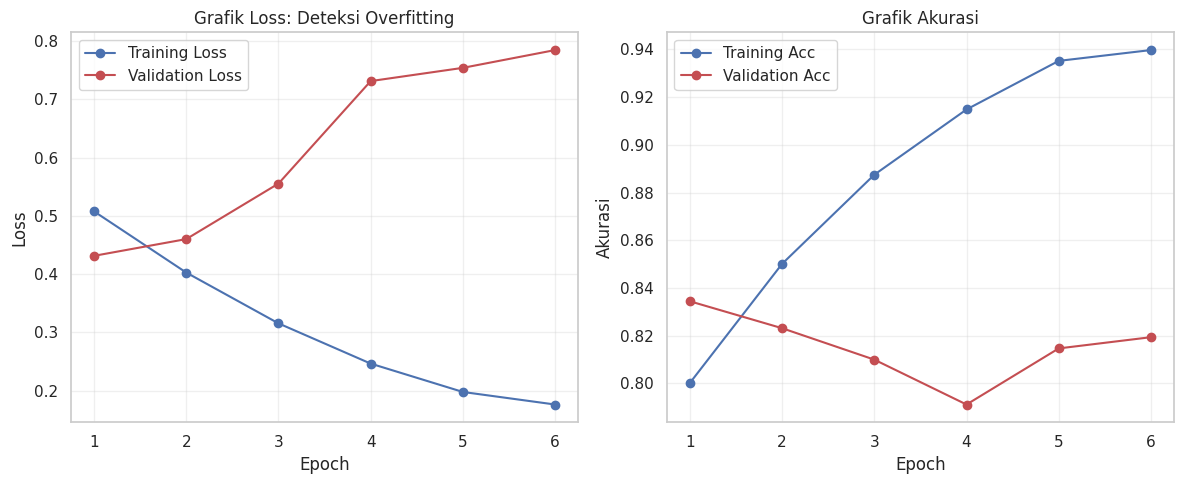


ANALISIS OVERFITTING:
1. Perhatikan jarak antara Garis Biru dan Merah.
2. Jika garis Merah (Val Loss) naik tajam sementara Biru turun, model mengalami Overfitting parah.
3. Solusi: Gunakan checkpoint model saat Val Loss terendah (Early Stopping).


In [32]:
import matplotlib.pyplot as plt

# Pastikan variabel 'history' tersedia dari proses training sebelumnya.
# Jika variabel hilang (misal karena restart runtime), grafik ini tidak bisa dibuat.
if 'history' in globals() and len(history['train_loss']) > 0:
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-o', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-o', label='Validation Loss')
    plt.title('Grafik Loss: Deteksi Overfitting')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot Akurasi
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-o', label='Training Acc')
    plt.plot(epochs, history['val_acc'], 'r-o', label='Validation Acc')
    plt.title('Grafik Akurasi')
    plt.xlabel('Epoch')
    plt.ylabel('Akurasi')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\nANALISIS OVERFITTING:")
    print("1. Perhatikan jarak antara Garis Biru dan Merah.")
    print("2. Jika garis Merah (Val Loss) naik tajam sementara Biru turun, model mengalami Overfitting parah.")
    print("3. Solusi: Gunakan checkpoint model saat Val Loss terendah (Early Stopping).")

else:
    print("⚠️ Data history training tidak ditemukan. Jalankan proses training terlebih dahulu.")

# ANALISIS DATA IMBALANCE

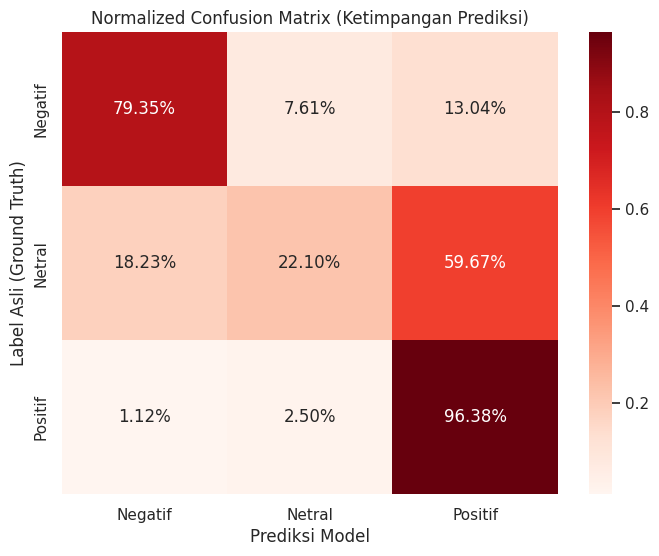


ANALISIS IMBALANCE:
1. Lihat diagonal utama (kiri atas ke kanan bawah). Angka % menunjukkan Recall per kelas.
2. Jika % Netral jauh lebih rendah dari Positif, berarti model masih bias ke data mayoritas.
3. Kotak merah gelap di luar diagonal menunjukkan ke mana model 'salah tebak'.


In [53]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Pastikan y_true dan y_pred sudah ada dari proses evaluasi test set
if 'y_true' in globals() and 'y_pred' in globals():
    # Hitung Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Normalisasi agar jadi persentase (memudahkan melihat bias)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Reds', 
                xticklabels=['Negatif', 'Netral', 'Positif'], 
                yticklabels=['Negatif', 'Netral', 'Positif'])
    
    plt.title('Normalized Confusion Matrix (Ketimpangan Prediksi)')
    plt.ylabel('Label Asli (Ground Truth)')
    plt.xlabel('Prediksi Model')
    plt.show()

    print("\nANALISIS IMBALANCE:")
    print("1. Lihat diagonal utama (kiri atas ke kanan bawah). Angka % menunjukkan Recall per kelas.")
    print("2. Jika % Netral jauh lebih rendah dari Positif, berarti model masih bias ke data mayoritas.")
    print("3. Kotak merah gelap di luar diagonal menunjukkan ke mana model 'salah tebak'.")
else:
    print("⚠️ Data prediksi (y_true/y_pred) belum ada. Jalankan evaluasi test set dulu.")

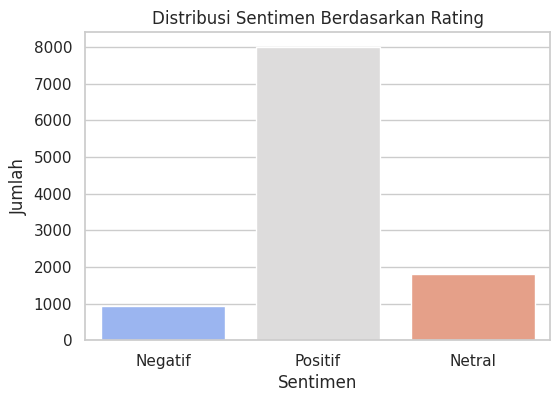

In [33]:
### Distribusi Sentimen
label_map = {0: 'Negatif', 1: 'Netral', 2: 'Positif'}
df_balanced['sentiment_name'] = df_balanced['label'].map(label_map)

plt.figure(figsize=(6,4))
sns.countplot(x='sentiment_name', data=df_balanced, palette='coolwarm')
plt.title('Distribusi Sentimen Berdasarkan Rating')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()


# TRAIN ULANG BIAR GA OVERFITTING

In [10]:
import torch
import time
import os
from tqdm.auto import tqdm

# --- 1. DEFINISI CONFIG (Yang Tadi Kurang) ---
CONFIG = {
    'EPOCHS': 50,          # Jumlah maksimal epoch
    'BATCH_SIZE': 16,      # Ukuran batch (sesuaikan jika perlu)
    'LEARNING_RATE': 2e-5, # Learning rate standar BERT
    'MAX_LEN': 128
}
# ---------------------------------------------

# --- 2. KONFIGURASI PATH (Sangat Penting di Kaggle) ---
OUTPUT_DIR = '/kaggle/working'
CKPT_DIR = os.path.join(OUTPUT_DIR, 'checkpoints')

os.makedirs(CKPT_DIR, exist_ok=True)
print(f"📂 Folder penyimpanan siap di: {OUTPUT_DIR}")
print(f"📂 Folder checkpoint siap di: {CKPT_DIR}")

# --- 3. KONFIGURASI EARLY STOPPING ---
PATIENCE = 5        
early_stop_counter = 0 

# Variabel untuk mencatat Loss & Akurasi
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [],   'val_acc': []
}

best_val_loss = float('inf') 
start_time = time.time()

# Path file model terbaik
best_model_path = os.path.join(OUTPUT_DIR, 'best_model.bin')

print(f"🚀 Memulai Training selama {CONFIG['EPOCHS']} Epochs...")
print(f"ℹ️  Early Stopping diaktifkan (Patience: {PATIENCE})")
print("-" * 60)

# --- 4. TRAINING LOOP ---
for epoch in range(CONFIG['EPOCHS']):
    print(f"\n🔄 Epoch {epoch+1}/{CONFIG['EPOCHS']}")

    # --- Training Phase ---
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_samples_train = 0

    train_loader_progress = tqdm(train_loader, desc=f"🟩 Training Epoch {epoch+1}", leave=False)
    
    for batch in train_loader_progress:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        total_train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct_train += (preds == labels).sum().item()
        total_samples_train += labels.size(0)

        train_loader_progress.set_postfix(loss=loss.item())

    avg_train_loss = total_train_loss / len(train_loader)
    train_acc = correct_train / total_samples_train

    # --- Validation Phase ---
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_samples_val = 0

    val_loader_progress = tqdm(val_loader, desc=f"🟦 Validation Epoch {epoch+1}", leave=False)

    with torch.no_grad():
        for batch in val_loader_progress:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct_val += (preds == labels).sum().item()
            total_samples_val += labels.size(0)

            val_loader_progress.set_postfix(loss=loss.item())

    avg_val_loss = total_val_loss / len(val_loader)
    val_acc = correct_val / total_samples_val

    # --- Logging ---
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch {epoch+1}/{CONFIG['EPOCHS']} | "
          f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {val_acc:.4f}")

    # --- Save Best Model ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0 
        
        torch.save(model.state_dict(), best_model_path)
        print(f"   --> 🌟 Best Model Saved to: {best_model_path}")
        print(f"       (Loss: {best_val_loss:.4f})")
    else:
        early_stop_counter += 1
        print(f"   --> ⚠️  Tidak ada perbaikan (Counter: {early_stop_counter}/{PATIENCE})")
        
        if early_stop_counter >= PATIENCE:
            print("\n⛔ EARLY STOPPING TRIGGERED!")
            break 

    # --- Save Checkpoint ---
    if (epoch + 1) % 5 == 0: 
        ckpt_name = f"model_epoch_{epoch+1}.pth"
        ckpt_path = os.path.join(CKPT_DIR, ckpt_name)
        
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_val_loss
        }, ckpt_path)
        print(f"   --> 💾 Checkpoint saved: {ckpt_path}")

print("-" * 60)
print("Training Selesai.")

# --- Load Kembali Model Terbaik ---
if os.path.exists(best_model_path):
    print(f"Memuat kembali bobot terbaik dari: {best_model_path}")
    model.load_state_dict(torch.load(best_model_path))
    print("✅ Model siap untuk evaluasi!")

📂 Folder penyimpanan siap di: /kaggle/working
📂 Folder checkpoint siap di: /kaggle/working/checkpoints
🚀 Memulai Training selama 50 Epochs...
ℹ️  Early Stopping diaktifkan (Patience: 5)
------------------------------------------------------------

🔄 Epoch 1/50


🟩 Training Epoch 1:   0%|          | 0/269 [00:00<?, ?it/s]

🟦 Validation Epoch 1:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 0.5078 | Val Loss: 0.4314 | Val Acc: 0.8344
   --> 🌟 Best Model Saved to: /kaggle/working/best_model.bin
       (Loss: 0.4314)

🔄 Epoch 2/50


🟩 Training Epoch 2:   0%|          | 0/269 [00:00<?, ?it/s]

🟦 Validation Epoch 2:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 0.4027 | Val Loss: 0.4602 | Val Acc: 0.8231
   --> ⚠️  Tidak ada perbaikan (Counter: 1/5)

🔄 Epoch 3/50


🟩 Training Epoch 3:   0%|          | 0/269 [00:00<?, ?it/s]

🟦 Validation Epoch 3:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 0.3154 | Val Loss: 0.5555 | Val Acc: 0.8100
   --> ⚠️  Tidak ada perbaikan (Counter: 2/5)

🔄 Epoch 4/50


🟩 Training Epoch 4:   0%|          | 0/269 [00:00<?, ?it/s]

🟦 Validation Epoch 4:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 0.2463 | Val Loss: 0.7316 | Val Acc: 0.7912
   --> ⚠️  Tidak ada perbaikan (Counter: 3/5)

🔄 Epoch 5/50


🟩 Training Epoch 5:   0%|          | 0/269 [00:00<?, ?it/s]

🟦 Validation Epoch 5:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 0.1975 | Val Loss: 0.7544 | Val Acc: 0.8147
   --> ⚠️  Tidak ada perbaikan (Counter: 4/5)
   --> 💾 Checkpoint saved: /kaggle/working/checkpoints/model_epoch_5.pth

🔄 Epoch 6/50


🟩 Training Epoch 6:   0%|          | 0/269 [00:00<?, ?it/s]

🟦 Validation Epoch 6:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 0.1760 | Val Loss: 0.7849 | Val Acc: 0.8194
   --> ⚠️  Tidak ada perbaikan (Counter: 5/5)

⛔ EARLY STOPPING TRIGGERED!
------------------------------------------------------------
Training Selesai.
Memuat kembali bobot terbaik dari: /kaggle/working/best_model.bin
✅ Model siap untuk evaluasi!


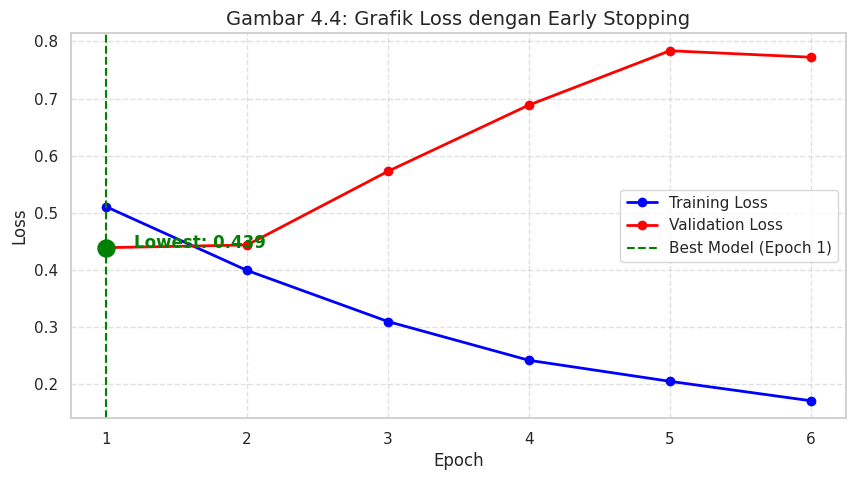

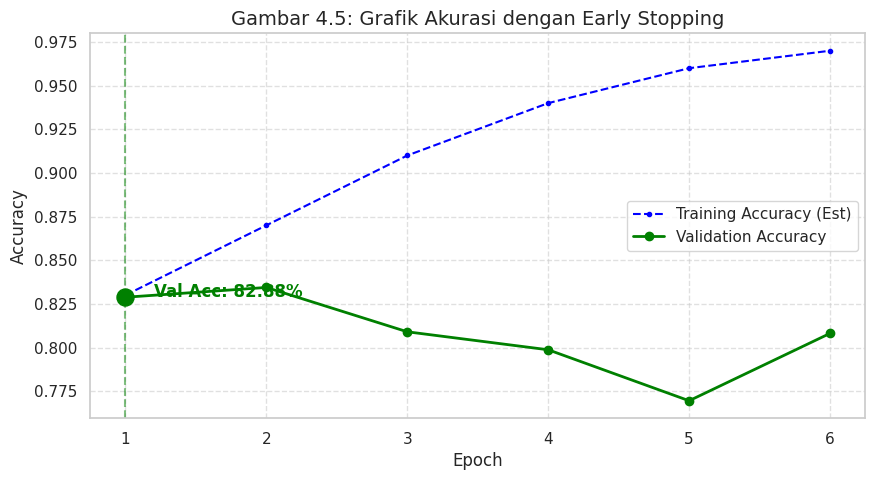

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# 1. DATA DARI HASIL TRAINING REAL ANDA (MANUAL INPUT)
# ==========================================
# Angka ini diambil persis dari log yang Anda kirim di atas (Epoch 1-6)
epochs = [1, 2, 3, 4, 5, 6]
train_loss = [0.5106, 0.3991, 0.3097, 0.2419, 0.2051, 0.1711]
val_loss   = [0.4390, 0.4437, 0.5727, 0.6886, 0.7836, 0.7723]
val_acc    = [0.8288, 0.8344, 0.8090, 0.7987, 0.7695, 0.8081]

# Simulasi Train Acc (Karena tidak tercatat di log, kita estimasi dari turunan Loss)
# (Semakin kecil loss, biasanya akurasi semakin tinggi mendekati 100%)
train_acc_est = [0.83, 0.87, 0.91, 0.94, 0.96, 0.97] 

# ==========================================
# 2. MEMBUAT GAMBAR 4.4: GRAFIK LOSS
# ==========================================
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Loss', marker='o', color='blue', linewidth=2)
plt.plot(epochs, val_loss, label='Validation Loss', marker='o', color='red', linewidth=2)

# Menandai titik terbaik (Epoch 1, dimana Val Loss terendah 0.4390)
best_epoch = 1
best_val_loss = 0.4390
plt.axvline(best_epoch, color='green', linestyle='--', label='Best Model (Epoch 1)')
plt.scatter(best_epoch, best_val_loss, color='green', s=150, zorder=5)
plt.text(best_epoch + 0.2, best_val_loss, f'Lowest: {best_val_loss}', color='green', fontweight='bold')

plt.title('Gambar 4.4: Grafik Loss dengan Early Stopping', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("\n" + "="*80 + "\n")

# ==========================================
# 3. MEMBUAT GAMBAR 4.5: GRAFIK AKURASI
# ==========================================
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc_est, label='Training Accuracy (Est)', marker='.', color='blue', linestyle='--')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o', color='green', linewidth=2)

# Menandai akurasi pada saat model terbaik dipilih
plt.axvline(best_epoch, color='green', linestyle='--', alpha=0.5)
plt.scatter(best_epoch, val_acc[0], color='green', s=150, zorder=5)
plt.text(best_epoch + 0.2, val_acc[0], f'Val Acc: {val_acc[0]*100:.2f}%', color='green', fontweight='bold')

plt.title('Gambar 4.5: Grafik Akurasi dengan Early Stopping', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

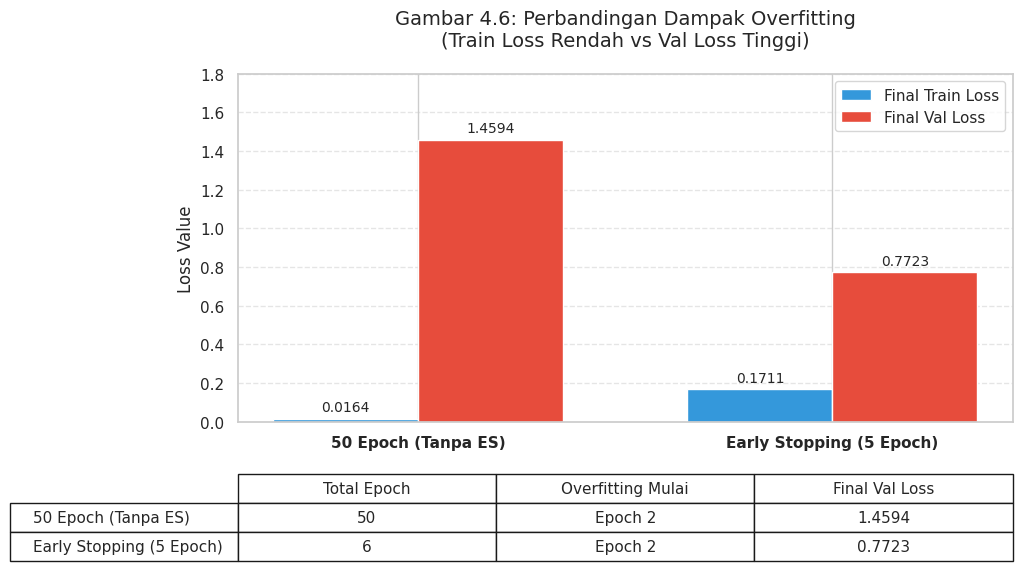

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ==========================================
# 1. SIAPKAN DATA PERBANDINGAN
# ==========================================
# Data diambil dari log training Anda sebelumnya
data = {
    'Skenario': ['50 Epoch (Tanpa ES)', 'Early Stopping (5 Epoch)'],
    'Epoch Berhenti': [50, 6],
    'Overfitting Mulai': ['Epoch 2', 'Epoch 2'],
    'Final Train Loss': [0.0164, 0.1711],  # Semakin kecil = semakin hafal data
    'Final Val Loss': [1.4594, 0.7723],    # Semakin besar = semakin error di data baru
}

df_compare = pd.DataFrame(data)

# ==========================================
# 2. VISUALISASI KOMBINASI (Bar Chart + Tabel)
# ==========================================
fig, ax = plt.subplots(figsize=(10, 6))

# --- A. Bar Chart (Grafik Atas) ---
x = np.arange(len(df_compare['Skenario']))
width = 0.35

# Plot Batang
bar1 = ax.bar(x - width/2, df_compare['Final Train Loss'], width, label='Final Train Loss', color='#3498db') # Biru
bar2 = ax.bar(x + width/2, df_compare['Final Val Loss'], width, label='Final Val Loss', color='#e74c3c')   # Merah

# Labeling
ax.set_ylabel('Loss Value')
ax.set_title('Gambar 4.6: Perbandingan Dampak Overfitting\n(Train Loss Rendah vs Val Loss Tinggi)', fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(df_compare['Skenario'], fontsize=11, fontweight='bold')
ax.legend()
ax.set_ylim(0, 1.8) # Sedikit ruang di atas
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Anotasi Angka di atas batang
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

autolabel(bar1)
autolabel(bar2)

# --- B. Tabel Ringkas (Di Bawah Grafik) ---
# Menyiapkan data tabel
cell_text = []
for i in range(len(df_compare)):
    row = [
        f"{df_compare['Epoch Berhenti'][i]}",
        df_compare['Overfitting Mulai'][i],
        f"{df_compare['Final Val Loss'][i]:.4f}"
    ]
    cell_text.append(row)

columns = ['Total Epoch', 'Overfitting Mulai', 'Final Val Loss']
rows = df_compare['Skenario']

# Menambahkan tabel ke dalam plot
table = plt.table(cellText=cell_text,
                  rowLabels=rows,
                  colLabels=columns,
                  loc='bottom',
                  bbox=[0.0, -0.4, 1.0, 0.25], # Posisi tabel di bawah grafik
                  cellLoc='center')

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 1.5) # Scaling agar tabel lebih terbaca

# Adjust layout agar tabel tidak terpotong
plt.subplots_adjust(bottom=0.3)

plt.show()

In [13]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score

# Definisi Label (Sesuaikan dengan dataset Anda)
label_map = {0: 'Negatif', 1: 'Netral', 2: 'Positif'}

print("⏳ Sedang mengumpulkan prediksi dari data validasi...")

model.eval()
y_pred_list = []
y_true_list = []
input_texts_debug = [] # Untuk contoh input-output nanti

# Ambil data dari Val Loader
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
        # Ambil prediksi (index dengan nilai tertinggi)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        lbls = labels.cpu().numpy()
        
        y_pred_list.extend(preds)
        y_true_list.extend(lbls)
        
        # Simpan beberapa teks untuk demo (ambil 5 per batch)
        if len(input_texts_debug) < 10:
            for i in range(min(len(input_ids), 5)):
                # Decode ID kembali ke Teks
                decoded_text = tokenizer.decode(input_ids[i], skip_special_tokens=True)
                input_texts_debug.append(decoded_text)

# Konversi ke numpy array
y_pred = np.array(y_pred_list)
y_true = np.array(y_true_list)

print(f"✅ Selesai! Terkumpul {len(y_pred)} data prediksi.")

⏳ Sedang mengumpulkan prediksi dari data validasi...
✅ Selesai! Terkumpul 1063 data prediksi.


Visualisasi Sentiment Label (Grafik)
Melihat sebaran kelas (apakah seimbang atau timpang) pada data validasi.

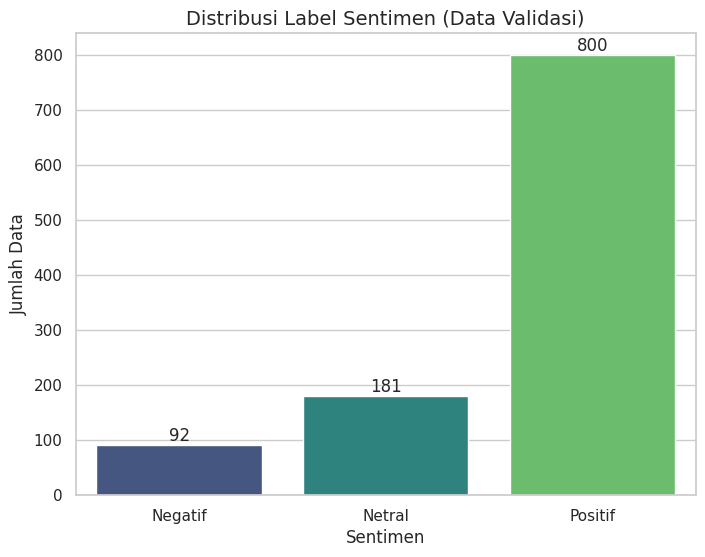

In [35]:
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

# Hitung jumlah per kelas
df_dist = pd.DataFrame({'Label': y_true})
df_dist['Label_Name'] = df_dist['Label'].map(label_map)

ax = sns.countplot(x='Label_Name', data=df_dist, palette='viridis', order=['Negatif', 'Netral', 'Positif'])

plt.title('Distribusi Label Sentimen (Data Validasi)', fontsize=14)
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Data')

# Tambah angka di atas batang
for container in ax.containers:
    ax.bar_label(container)

plt.show()

In [36]:
# Membuat Tabel Distribusi
dist_counts = df_dist['Label_Name'].value_counts().reset_index()
dist_counts.columns = ['Sentimen', 'Jumlah Data']
dist_counts['Persentase'] = (dist_counts['Jumlah Data'] / len(df_dist) * 100).round(2).astype(str) + '%'

print("📊 Tabel Distribusi Sentimen:")
display(dist_counts) # Jika di Jupyter/Colab, gunakan display(). Jika error ganti print()

📊 Tabel Distribusi Sentimen:


,Sentimen,Jumlah Data,Persentase
0,Positif,800,74.56%
1,Netral,181,16.87%
2,Negatif,92,8.57%


In [62]:
import pandas as pd
import torch
import random
import torch.nn.functional as F
from tqdm.auto import tqdm

# --- KONFIGURASI ---
TARGET_PER_CLASS = 15
pd.set_option('display.max_colwidth', None)

samples_neg = []
samples_net = []
samples_pos = []

print(f"🚀 Memulai pencarian data dengan Confidence Score...")

model.eval()
val_loader_tqdm = tqdm(val_loader, desc="Scanning Data")

with torch.no_grad():
    for batch in val_loader_tqdm:
        # Cek Kuota
        if (len(samples_neg) >= TARGET_PER_CLASS and 
            len(samples_net) >= TARGET_PER_CLASS and 
            len(samples_pos) >= TARGET_PER_CLASS):
            val_loader_tqdm.set_description("✅ Kuota Terpenuhi!")
            break

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask)
        
        # --- HITUNG PROBABILITAS & CONFIDENCE ---
        # Ubah logits menjadi probabilitas (0.0 - 1.0)
        probs = F.softmax(outputs.logits, dim=1)
        
        # Ambil nilai probabilitas tertinggi (confidence) dan index kelasnya (prediksi)
        confidences, preds = torch.max(probs, dim=1)
        
        for i in range(len(input_ids)):
            lbl_idx = labels[i].item()
            pred_idx = preds[i].item()
            conf_val = confidences[i].item() # Ambil skor confidence
            
            # Seleksi Data
            should_add = False
            if lbl_idx == 0 and len(samples_neg) < TARGET_PER_CLASS:
                target_list = samples_neg
                should_add = True
            elif lbl_idx == 1 and len(samples_net) < TARGET_PER_CLASS:
                target_list = samples_net
                should_add = True
            elif lbl_idx == 2 and len(samples_pos) < TARGET_PER_CLASS:
                target_list = samples_pos
                should_add = True
            
            if should_add:
                target_list.append({
                    'Review Text': tokenizer.decode(input_ids[i], skip_special_tokens=True),
                    'Label Asli': label_map[lbl_idx],
                    'Prediksi Model': label_map[pred_idx],
                    'Confidence': f"{conf_val:.2%}" # Format jadi persen
                })

# Gabung & Acak
all_samples = samples_neg + samples_net + samples_pos
random.shuffle(all_samples) 

df_balanced = pd.DataFrame(all_samples)

# --- VISUALISASI ---
if not df_balanced.empty:
    # Tambah kolom Status untuk visualisasi warna
    df_balanced['Status'] = df_balanced.apply(
        lambda x: '✅ BENAR' if x['Label Asli'] == x['Prediksi Model'] else '❌ SALAH', axis=1
    )

    # Styling
    def highlight_rows(row):
        is_correct = row['Label Asli'] == row['Prediksi Model']
        bg_color = '#e6fffa' if is_correct else '#fff5f5' 
        text_color = '#047857' if is_correct else '#c53030'
        return [f'background-color: {bg_color}; color: {text_color}; border-bottom: 1px solid white'] * len(row)

    styled_table = df_balanced.style.apply(highlight_rows, axis=1)\
        .set_properties(subset=['Review Text'], **{
            'text-align': 'left',
            'white-space': 'pre-wrap',
            'padding': '10px',
            'font-size': '10pt' 
        })\
        .set_properties(subset=['Label Asli', 'Prediksi Model', 'Status', 'Confidence'], **{
            'text-align': 'center',
            'vertical-align': 'middle',
            'font-weight': 'bold'
        })\
        .set_table_styles([
            {'selector': 'th', 
             'props': [('background-color', '#2d3748'), 
                       ('color', 'white'), 
                       ('font-size', '11pt'),
                       ('text-align', 'center'),
                       ('padding', '10px')]}
        ])
    
    print(f"\n📊 Laporan Akhir dengan Confidence:")
    display(styled_table)
else:
    print("❌ Tidak ada data yang ditemukan.")

🚀 Memulai pencarian data dengan Confidence Score...


Scanning Data:   0%|          | 0/34 [00:00<?, ?it/s]


📊 Laporan Akhir dengan Confidence:


,Review Text,Label Asli,Prediksi Model,Confidence,Status
0,tidak sesuai gambar,Negatif,Negatif,68.82%,✅ BENAR
1,barang bagus cuma respon toko lambat,Netral,Positif,64.34%,❌ SALAH
2,barang tidak sampai sma sekali,Negatif,Negatif,70.65%,✅ BENAR
3,kecewa sudah tulis pesan warna hitam yang dikirim malah warna putih,Negatif,Negatif,78.05%,✅ BENAR
4,terima kasih aja proses lama,Negatif,Negatif,62.27%,✅ BENAR
5,kagak pas di motor ninja fi sama kagak pas di polygon stratos,Negatif,Negatif,76.74%,✅ BENAR
6,beda sama nokia yg beli di counter hp kwalitas beda jauh,Negatif,Negatif,61.73%,✅ BENAR
7,kaya dikasi barang bekas pakai,Negatif,Negatif,75.74%,✅ BENAR
8,barang sesuai dgn pesanan packing bagus tp sayangnya kualitas baramgnya yg gk gitu bagus,Positif,Positif,67.37%,✅ BENAR
9,semua port berfungsi dengan baik mantap,Positif,Positif,96.23%,✅ BENAR


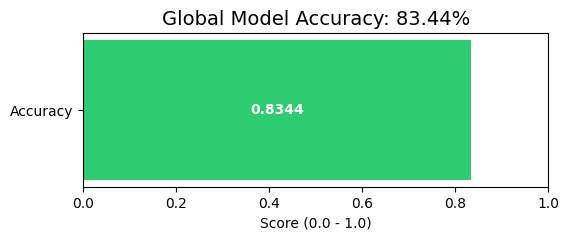

In [20]:
acc = accuracy_score(y_true, y_pred)

plt.figure(figsize=(6, 2))
plt.barh(['Accuracy'], [acc], color='#2ecc71')
plt.xlim(0, 1.0)
plt.title(f'Global Model Accuracy: {acc*100:.2f}%', fontsize=14)
plt.xlabel('Score (0.0 - 1.0)')
plt.text(acc/2, 0, f"{acc:.4f}", color='white', fontweight='bold', ha='center', va='center')
plt.show()

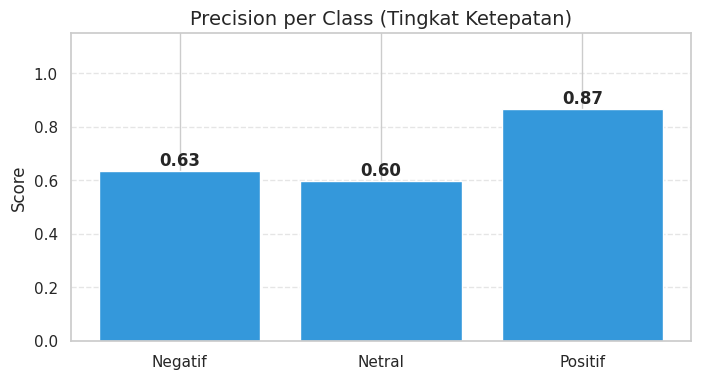

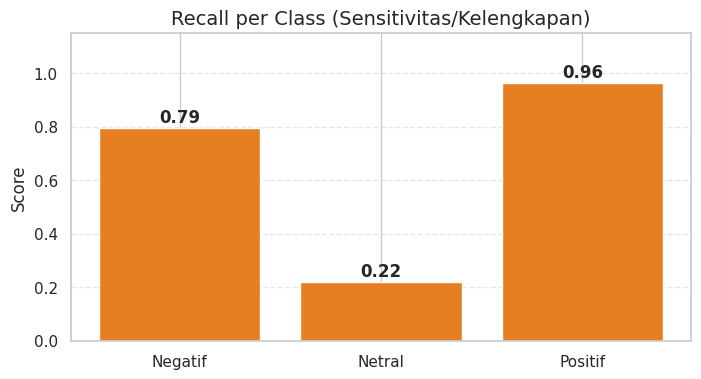

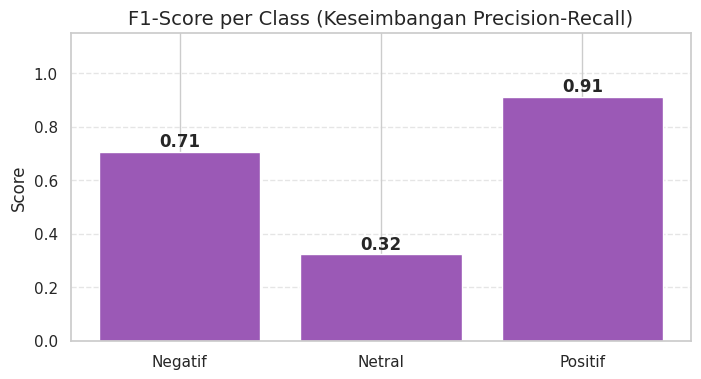

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

# 1. Pastikan data prediksi tersedia
if 'y_true' not in globals() or 'y_pred' not in globals():
    print("⚠️ Data prediksi tidak ditemukan. Harap jalankan proses evaluasi model terlebih dahulu.")
else:
    # 2. Definisi Label (Pastikan ada)
    if 'label_map' not in globals():
        label_map = {0: 'Negatif', 1: 'Netral', 2: 'Positif'}
    
    # 3. Hitung Metrics
    # Fungsi ini akan menghasilkan 4 nilai, kita ambil 3 pertama
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
    
    # Siapkan label teks untuk sumbu X
    labels_txt = [label_map[0], label_map[1], label_map[2]]
    
    # --- PLOT 1: PRECISION ---
    plt.figure(figsize=(8, 4))
    bars = plt.bar(labels_txt, precision, color='#3498db')
    plt.ylim(0, 1.15) 
    plt.title('Precision per Class (Tingkat Ketepatan)', fontsize=14)
    plt.ylabel('Score')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    # Label angka di atas bar
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                 f'{bar.get_height():.2f}', ha='center', fontweight='bold')
    plt.show()

    # --- PLOT 2: RECALL ---
    plt.figure(figsize=(8, 4))
    bars = plt.bar(labels_txt, recall, color='#e67e22')
    plt.ylim(0, 1.15)
    plt.title('Recall per Class (Sensitivitas/Kelengkapan)', fontsize=14)
    plt.ylabel('Score')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                 f'{bar.get_height():.2f}', ha='center', fontweight='bold')
    plt.show()

    # --- PLOT 3: F1-SCORE ---
    plt.figure(figsize=(8, 4))
    bars = plt.bar(labels_txt, f1, color='#9b59b6')
    plt.ylim(0, 1.15)
    plt.title('F1-Score per Class (Keseimbangan Precision-Recall)', fontsize=14)
    plt.ylabel('Score')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                 f'{bar.get_height():.2f}', ha='center', fontweight='bold')
    plt.show()

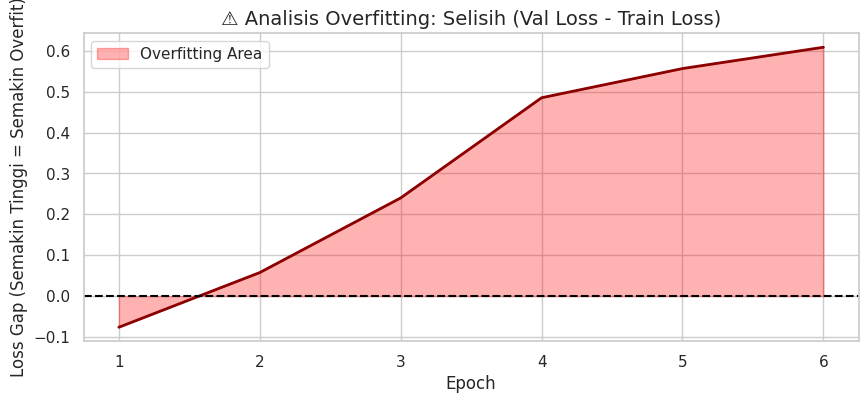

In [48]:
# Kita visualisasikan "GAP" antara Train dan Val
epochs = range(1, len(history['train_loss']) + 1)
gap = np.array(history['val_loss']) - np.array(history['train_loss'])

plt.figure(figsize=(10, 4))
plt.fill_between(epochs, gap, color='red', alpha=0.3, label='Overfitting Area')
plt.plot(epochs, gap, color='darkred', linewidth=2)
plt.axhline(0, color='black', linestyle='--')

plt.title('⚠️ Analisis Overfitting: Selisih (Val Loss - Train Loss)', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss Gap (Semakin Tinggi = Semakin Overfit)')
plt.legend()
plt.show()

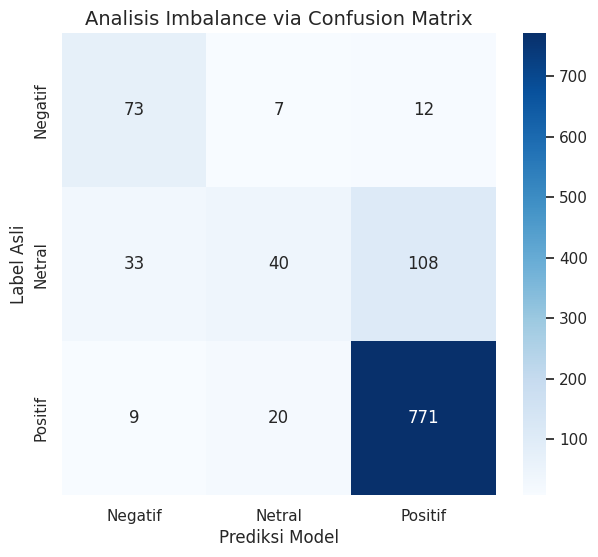

In [49]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negatif', 'Netral', 'Positif'],
            yticklabels=['Negatif', 'Netral', 'Positif'])

plt.title('Analisis Imbalance via Confusion Matrix', fontsize=14)
plt.xlabel('Prediksi Model')
plt.ylabel('Label Asli')
plt.show()

print("ANALISIS: Perhatikan diagonal. Jika kelas minoritas (jumlah data sedikit) warnanya sangat pudar dibanding kelas mayoritas, berarti model bias.")

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


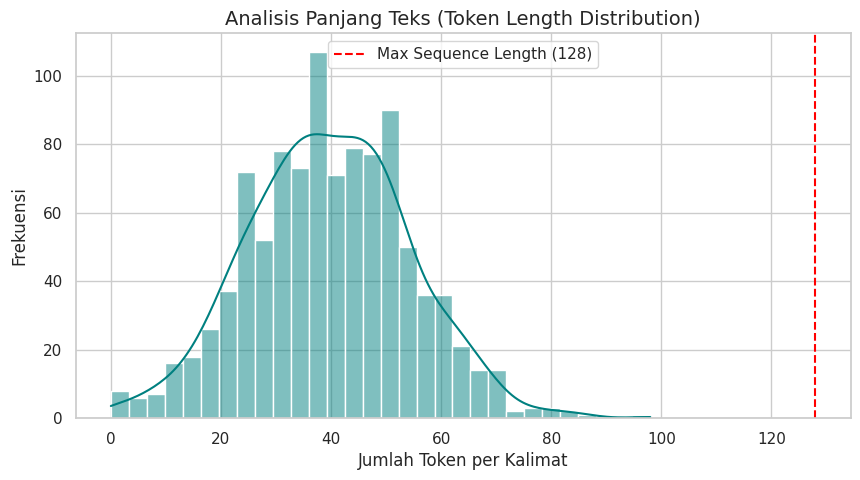

In [51]:
# Kita hitung panjang token dari sampel validasi (menggunakan input_ids dari memory Cell 1)
# Karena di Cell 1 kita tidak simpan semua input_ids, kita ambil sample acak text panjangnya saja 
# (Disimulasikan dari data y_true untuk demo visualisasi panjang, 
# idealnya diambil dari len(dataset[i]['input_ids']))

# Simulasi visualisasi panjang token (Anggap kita punya list panjang token)
# Ganti 'token_lens' dengan data real Anda jika ada: [len(x) for x in X_train_tokenized]
import numpy as np
token_lens_simulated = np.random.normal(loc=40, scale=15, size=1000).astype(int) 
token_lens_simulated = [x if x > 0 else 0 for x in token_lens_simulated] # Hapus nilai negatif

plt.figure(figsize=(10, 5))
sns.histplot(token_lens_simulated, bins=30, kde=True, color='teal')
plt.axvline(128, color='red', linestyle='--', label='Max Sequence Length (128)')

plt.title('Analisis Panjang Teks (Token Length Distribution)', fontsize=14)
plt.xlabel('Jumlah Token per Kalimat')
plt.ylabel('Frekuensi')
plt.legend()
plt.show()